In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "z"
quantile = "2"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  3.19it/s]

11it [00:00,  4.49it/s]

22it [00:00,  6.31it/s]

31it [00:00,  8.73it/s]

41it [00:00, 12.01it/s]

53it [00:00, 16.43it/s]

65it [00:00, 22.17it/s]

75it [00:01, 28.84it/s]

86it [00:01, 36.73it/s]

96it [00:01, 43.49it/s]

106it [00:01, 52.32it/s]

118it [00:01, 62.42it/s]

128it [00:01, 70.04it/s]

139it [00:01, 78.52it/s]

150it [00:01, 82.75it/s]

161it [00:01, 88.47it/s]

172it [00:02, 89.82it/s]

184it [00:02, 96.40it/s]

196it [00:02, 101.69it/s]

207it [00:02, 103.37it/s]

218it [00:02, 95.10it/s] 

229it [00:02, 98.57it/s]

241it [00:02, 103.82it/s]

252it [00:02, 104.88it/s]

263it [00:02, 98.82it/s] 

274it [00:03, 98.73it/s]

286it [00:03, 103.01it/s]

297it [00:03, 100.55it/s]

309it [00:03, 104.40it/s]

321it [00:03, 107.62it/s]

333it [00:03, 109.63it/s]

345it [00:03, 104.09it/s]

356it [00:03, 92.78it/s] 

368it [00:03, 98.89it/s]

380it [00:04, 103.04it/s]

392it [00:04, 107.04it/s]

403it [00:04, 105.25it/s]

414it [00:04, 104.03it/s]

426it [00:04, 108.07it/s]

438it [00:04, 111.17it/s]

451it [00:04, 113.82it/s]

463it [00:04, 114.99it/s]

476it [00:04, 116.48it/s]

488it [00:04, 117.41it/s]

501it [00:05, 118.78it/s]

513it [00:05, 118.84it/s]

525it [00:05, 118.14it/s]

537it [00:05, 118.47it/s]

549it [00:05, 118.26it/s]

561it [00:05, 117.82it/s]

573it [00:05, 112.57it/s]

585it [00:05, 109.17it/s]

597it [00:05, 111.86it/s]

609it [00:06, 113.21it/s]

621it [00:06, 114.32it/s]

633it [00:06, 110.89it/s]

645it [00:06, 112.80it/s]

657it [00:06, 114.47it/s]

669it [00:06, 114.42it/s]

681it [00:06, 115.46it/s]

693it [00:06, 111.94it/s]

705it [00:06, 114.11it/s]

717it [00:06, 115.02it/s]

729it [00:07, 115.50it/s]

741it [00:07, 116.02it/s]

753it [00:07, 117.15it/s]

765it [00:07, 117.93it/s]

777it [00:07, 111.93it/s]

789it [00:07, 113.11it/s]

801it [00:07, 114.25it/s]

813it [00:07, 98.25it/s] 

825it [00:07, 103.58it/s]

837it [00:08, 107.16it/s]

849it [00:08, 109.64it/s]

861it [00:08, 110.74it/s]

873it [00:08, 113.04it/s]

885it [00:08, 114.53it/s]

897it [00:08, 114.19it/s]

909it [00:08, 96.53it/s] 

920it [00:08, 98.92it/s]

931it [00:08, 101.85it/s]

942it [00:09, 103.85it/s]

954it [00:09, 105.88it/s]

965it [00:09, 102.96it/s]

976it [00:09, 99.31it/s] 

988it [00:09, 103.73it/s]

999it [00:09, 104.63it/s]

1011it [00:09, 108.45it/s]

1022it [00:09, 105.45it/s]

1034it [00:09, 108.72it/s]

1046it [00:10, 110.69it/s]

1058it [00:10, 112.20it/s]

1070it [00:10, 111.58it/s]

1082it [00:10, 98.81it/s] 

1093it [00:10, 101.31it/s]

1105it [00:10, 105.46it/s]

1117it [00:10, 108.14it/s]

1128it [00:10, 106.89it/s]

1140it [00:10, 109.18it/s]

1152it [00:11, 111.08it/s]

1164it [00:11, 112.92it/s]

1176it [00:11, 114.03it/s]

1188it [00:11, 114.56it/s]

1200it [00:11, 115.07it/s]

1212it [00:11, 115.36it/s]

1224it [00:11, 113.00it/s]

1236it [00:11, 114.72it/s]

1248it [00:11, 115.62it/s]

1260it [00:11, 111.96it/s]

1272it [00:12, 111.08it/s]

1284it [00:12, 107.33it/s]

1295it [00:12, 96.86it/s] 

1305it [00:12, 91.53it/s]

1315it [00:12, 93.20it/s]

1327it [00:12, 99.32it/s]

1338it [00:12, 100.70it/s]

1349it [00:12, 96.06it/s] 

1361it [00:12, 100.79it/s]

1373it [00:13, 104.44it/s]

1385it [00:13, 108.13it/s]

1397it [00:13, 110.89it/s]

1409it [00:13, 108.81it/s]

1420it [00:13, 91.13it/s] 

1430it [00:13, 87.61it/s]

1442it [00:13, 93.98it/s]

1454it [00:13, 98.73it/s]

1465it [00:14, 89.72it/s]

1477it [00:14, 95.45it/s]

1489it [00:14, 101.03it/s]

1501it [00:14, 105.21it/s]

1512it [00:14, 105.67it/s]

1523it [00:14, 105.74it/s]

1535it [00:14, 108.74it/s]

1547it [00:14, 111.05it/s]

1559it [00:14, 111.98it/s]

1571it [00:15, 113.53it/s]

1583it [00:15, 109.79it/s]

1595it [00:15, 109.16it/s]

1607it [00:15, 111.42it/s]

1619it [00:15, 113.14it/s]

1631it [00:15, 113.67it/s]

1643it [00:15, 113.93it/s]

1655it [00:15, 111.78it/s]

1667it [00:15, 112.49it/s]

1679it [00:15, 105.88it/s]

1691it [00:16, 108.41it/s]

1703it [00:16, 111.15it/s]

1715it [00:16, 113.00it/s]

1727it [00:16, 113.55it/s]

1739it [00:16, 105.86it/s]

1750it [00:16, 94.22it/s] 

1762it [00:16, 99.19it/s]

1773it [00:16, 95.94it/s]

1783it [00:17, 85.83it/s]

1795it [00:17, 92.46it/s]

1807it [00:17, 98.96it/s]

1819it [00:17, 104.00it/s]

1831it [00:17, 107.89it/s]

1843it [00:17, 110.07it/s]

1855it [00:17, 112.22it/s]

1867it [00:17, 113.16it/s]

1879it [00:17, 110.70it/s]

1891it [00:18, 110.20it/s]

1903it [00:18, 111.84it/s]

1915it [00:18, 114.02it/s]

1927it [00:18, 114.46it/s]

1939it [00:18, 115.52it/s]

1951it [00:18, 116.48it/s]

1963it [00:18, 115.06it/s]

1975it [00:18, 114.84it/s]

1987it [00:18, 115.30it/s]

1999it [00:18, 115.33it/s]

2011it [00:19, 101.35it/s]

2022it [00:19, 102.25it/s]

2033it [00:19, 104.25it/s]

2044it [00:19, 93.18it/s] 

2054it [00:19, 86.01it/s]

2063it [00:19, 77.52it/s]

2072it [00:19, 80.87it/s]

2084it [00:19, 88.67it/s]

2095it [00:20, 92.54it/s]

2107it [00:20, 98.94it/s]

2119it [00:20, 104.05it/s]

2131it [00:20, 107.67it/s]

2143it [00:20, 111.05it/s]

2155it [00:20, 110.42it/s]

2167it [00:20, 110.31it/s]

2179it [00:20, 110.94it/s]

2191it [00:20, 108.17it/s]

2202it [00:21, 96.24it/s] 

2212it [00:21, 84.47it/s]

2224it [00:21, 91.86it/s]

2234it [00:21, 90.45it/s]

2246it [00:21, 96.74it/s]

2258it [00:21, 101.13it/s]

2270it [00:21, 104.22it/s]

2281it [00:21, 90.41it/s] 

2293it [00:21, 96.30it/s]

2305it [00:22, 101.22it/s]

2317it [00:22, 104.22it/s]

2328it [00:22, 105.07it/s]

2340it [00:22, 107.76it/s]

2352it [00:22, 110.41it/s]

2364it [00:22, 112.41it/s]

2376it [00:22, 114.16it/s]

2388it [00:22, 114.98it/s]

2400it [00:22, 112.63it/s]

2412it [00:23, 111.90it/s]

2424it [00:23, 112.05it/s]

2436it [00:23, 99.73it/s] 

2447it [00:23, 91.43it/s]

2457it [00:23, 87.91it/s]

2467it [00:23, 85.10it/s]

2478it [00:23, 90.73it/s]

2490it [00:23, 97.06it/s]

2502it [00:23, 102.48it/s]

2514it [00:24, 106.72it/s]

2526it [00:24, 109.90it/s]

2538it [00:24, 111.92it/s]

2550it [00:24, 102.88it/s]

2562it [00:24, 106.55it/s]

2573it [00:24, 107.14it/s]

2585it [00:24, 109.15it/s]

2597it [00:24, 111.55it/s]

2609it [00:24, 112.58it/s]

2621it [00:25, 114.02it/s]

2633it [00:25, 113.90it/s]

2645it [00:25, 113.45it/s]

2657it [00:25, 110.68it/s]

2669it [00:25, 112.05it/s]

2681it [00:25, 113.40it/s]

2693it [00:25, 114.42it/s]

2705it [00:25, 114.92it/s]

2717it [00:25, 104.05it/s]

2728it [00:26, 103.42it/s]

2740it [00:26, 107.22it/s]

2752it [00:26, 109.47it/s]

2764it [00:26, 111.18it/s]

2776it [00:26, 110.04it/s]

2788it [00:26, 111.21it/s]

2800it [00:26, 110.59it/s]

2812it [00:26, 106.04it/s]

2823it [00:26, 97.79it/s] 

2835it [00:27, 102.50it/s]

2847it [00:27, 106.15it/s]

2858it [00:27, 100.46it/s]

2871it [00:27, 106.16it/s]

2883it [00:27, 109.51it/s]

2895it [00:27, 112.07it/s]

2907it [00:27, 114.16it/s]

2919it [00:27, 115.58it/s]

2932it [00:27, 117.04it/s]

2944it [00:27, 114.51it/s]

2956it [00:28, 110.74it/s]

2968it [00:28, 110.70it/s]

2980it [00:28, 112.88it/s]

2992it [00:28, 114.16it/s]

3004it [00:28, 113.42it/s]

3016it [00:28, 101.97it/s]

3028it [00:28, 105.08it/s]

3040it [00:28, 107.60it/s]

3051it [00:28, 108.16it/s]

3063it [00:29, 109.81it/s]

3075it [00:29, 108.91it/s]

3087it [00:29, 110.06it/s]

3099it [00:29, 111.71it/s]

3111it [00:29, 113.30it/s]

3123it [00:29, 108.42it/s]

3135it [00:29, 110.73it/s]

3147it [00:29, 112.30it/s]

3159it [00:29, 113.13it/s]

3171it [00:30, 113.30it/s]

3183it [00:30, 112.56it/s]

3195it [00:30, 111.28it/s]

3207it [00:30, 107.75it/s]

3219it [00:30, 110.61it/s]

3231it [00:30, 112.37it/s]

3243it [00:30, 113.70it/s]

3255it [00:30, 114.77it/s]

3267it [00:30, 111.26it/s]

3279it [00:31, 112.71it/s]

3291it [00:31, 114.22it/s]

3303it [00:31, 114.32it/s]

3315it [00:31, 114.09it/s]

3327it [00:31, 114.16it/s]

3339it [00:31, 112.54it/s]

3351it [00:31, 114.19it/s]

3363it [00:31, 115.53it/s]

3375it [00:31, 116.35it/s]

3388it [00:31, 117.69it/s]

3400it [00:32, 114.22it/s]

3412it [00:32, 114.87it/s]

3424it [00:32, 115.69it/s]

3436it [00:32, 116.57it/s]

3448it [00:32, 117.01it/s]

3460it [00:32, 117.33it/s]

3472it [00:32, 116.39it/s]

3484it [00:32, 115.50it/s]

3496it [00:32, 115.29it/s]

3508it [00:32, 116.02it/s]

3520it [00:33, 108.59it/s]

3531it [00:33, 99.41it/s] 

3543it [00:33, 104.01it/s]

3555it [00:33, 107.91it/s]

3567it [00:33, 110.36it/s]

3579it [00:33, 112.39it/s]

3591it [00:33, 113.18it/s]

3603it [00:33, 115.12it/s]

3615it [00:33, 115.37it/s]

3627it [00:34, 116.08it/s]

3639it [00:34, 117.11it/s]

3651it [00:34, 117.47it/s]

3663it [00:34, 117.88it/s]

3675it [00:34, 117.81it/s]

3687it [00:34, 116.24it/s]

3699it [00:34, 116.01it/s]

3711it [00:34, 115.43it/s]

3723it [00:34, 102.44it/s]

3735it [00:35, 105.78it/s]

3746it [00:35, 102.57it/s]

3758it [00:35, 106.91it/s]

3770it [00:35, 110.36it/s]

3782it [00:35, 112.24it/s]

3794it [00:35, 113.20it/s]

3806it [00:35, 114.97it/s]

3818it [00:35, 116.24it/s]

3830it [00:35, 117.01it/s]

3842it [00:36, 108.67it/s]

3854it [00:36, 110.29it/s]

3866it [00:36, 112.04it/s]

3878it [00:36, 114.01it/s]

3890it [00:36, 114.03it/s]

3902it [00:36, 96.10it/s] 

3913it [00:36, 93.74it/s]

3925it [00:36, 99.66it/s]

3937it [00:36, 103.67it/s]

3949it [00:37, 107.04it/s]

3961it [00:37, 108.69it/s]

3973it [00:37, 111.66it/s]

3985it [00:37, 112.57it/s]

3997it [00:37, 111.47it/s]

4009it [00:37, 110.73it/s]

4021it [00:37, 108.83it/s]

4033it [00:37, 111.15it/s]

4045it [00:37, 113.36it/s]

4057it [00:37, 114.51it/s]

4069it [00:38, 113.21it/s]

4081it [00:38, 115.10it/s]

4093it [00:38, 116.28it/s]

4106it [00:38, 117.58it/s]

4119it [00:38, 118.32it/s]

4131it [00:38, 116.38it/s]

4143it [00:38, 117.14it/s]

4155it [00:38, 117.70it/s]

4160it [00:38, 107.08it/s]


0it [00:00, ?it/s]

11it [00:00, 106.70it/s]

Number of empty sat catalogs is 10


24it [00:00, 110.55it/s]

37it [00:00, 113.37it/s]

49it [00:00, 112.95it/s]

62it [00:00, 116.25it/s]

75it [00:00, 118.10it/s]

86it [00:00, 114.45it/s]

99it [00:00, 117.01it/s]

111it [00:00, 117.39it/s]

124it [00:01, 119.44it/s]

137it [00:01, 120.99it/s]

150it [00:01, 121.48it/s]

163it [00:01, 122.75it/s]

176it [00:01, 123.71it/s]

189it [00:01, 123.58it/s]

202it [00:01, 124.21it/s]

215it [00:01, 124.39it/s]

228it [00:01, 122.82it/s]

241it [00:02, 120.09it/s]

254it [00:02, 113.81it/s]

267it [00:02, 116.92it/s]

280it [00:02, 119.30it/s]

292it [00:02, 111.91it/s]

304it [00:02, 113.13it/s]

317it [00:02, 115.84it/s]

329it [00:02, 116.73it/s]

341it [00:02, 116.16it/s]

354it [00:02, 119.18it/s]

366it [00:03, 104.56it/s]

378it [00:03, 106.61it/s]

391it [00:03, 110.68it/s]

404it [00:03, 114.23it/s]

416it [00:03, 115.19it/s]

429it [00:03, 118.30it/s]

442it [00:03, 119.70it/s]

455it [00:03, 104.64it/s]

466it [00:04, 101.47it/s]

477it [00:04, 94.48it/s] 

487it [00:04, 92.71it/s]

497it [00:04, 91.20it/s]

508it [00:04, 94.84it/s]

521it [00:04, 101.69it/s]

532it [00:04, 91.77it/s] 

544it [00:04, 97.44it/s]

557it [00:04, 104.70it/s]

570it [00:05, 110.39it/s]

582it [00:05, 100.33it/s]

593it [00:05, 96.84it/s] 

604it [00:05, 96.18it/s]

616it [00:05, 101.98it/s]

629it [00:05, 107.67it/s]

641it [00:05, 106.68it/s]

653it [00:05, 108.33it/s]

665it [00:05, 110.00it/s]

677it [00:06, 97.92it/s] 

688it [00:06, 99.42it/s]

701it [00:06, 106.13it/s]

714it [00:06, 85.18it/s] 

724it [00:06, 88.36it/s]

734it [00:06, 86.51it/s]

744it [00:06, 85.63it/s]

753it [00:07, 84.98it/s]

765it [00:07, 92.16it/s]

778it [00:07, 99.24it/s]

791it [00:07, 105.30it/s]

804it [00:07, 110.31it/s]

817it [00:07, 114.39it/s]

830it [00:07, 114.83it/s]

842it [00:07, 101.29it/s]

853it [00:07, 95.90it/s] 

863it [00:08, 92.98it/s]

873it [00:08, 90.21it/s]

884it [00:08, 94.85it/s]

897it [00:08, 102.35it/s]

910it [00:08, 108.36it/s]

923it [00:08, 113.34it/s]

936it [00:08, 115.99it/s]

948it [00:08, 102.18it/s]

959it [00:08, 102.68it/s]

971it [00:09, 106.73it/s]

983it [00:09, 110.08it/s]

996it [00:09, 111.66it/s]

1008it [00:09, 103.87it/s]

1020it [00:09, 107.38it/s]

1033it [00:09, 112.82it/s]

1047it [00:09, 117.44it/s]

1060it [00:09, 120.23it/s]

1073it [00:09, 122.54it/s]

1086it [00:10, 124.23it/s]

1099it [00:10, 124.87it/s]

1112it [00:10, 125.43it/s]

1125it [00:10, 125.91it/s]

1138it [00:10, 126.58it/s]

1152it [00:10, 127.91it/s]

1165it [00:10, 127.58it/s]

1178it [00:10, 127.65it/s]

1192it [00:10, 129.06it/s]

1206it [00:10, 129.59it/s]

1220it [00:11, 129.81it/s]

1233it [00:11, 128.72it/s]

1246it [00:11, 128.59it/s]

1259it [00:11, 127.91it/s]

1272it [00:11, 128.46it/s]

1286it [00:11, 129.13it/s]

1300it [00:11, 129.48it/s]

1313it [00:11, 128.20it/s]

1326it [00:11, 128.11it/s]

1339it [00:11, 127.17it/s]

1352it [00:12, 126.61it/s]

1365it [00:12, 110.94it/s]

1378it [00:12, 113.99it/s]

1391it [00:12, 116.85it/s]

1404it [00:12, 119.17it/s]

1417it [00:12, 115.07it/s]

1429it [00:12, 114.91it/s]

1441it [00:12, 113.88it/s]

1453it [00:13, 111.84it/s]

1465it [00:13, 92.82it/s] 

1478it [00:13, 100.74it/s]

1489it [00:13, 102.06it/s]

1502it [00:13, 108.80it/s]

1515it [00:13, 114.14it/s]

1528it [00:13, 118.39it/s]

1542it [00:13, 121.41it/s]

1555it [00:13, 123.80it/s]

1568it [00:14, 125.22it/s]

1581it [00:14, 121.67it/s]

1594it [00:14, 119.15it/s]

1607it [00:14, 110.43it/s]

1620it [00:14, 114.88it/s]

1633it [00:14, 118.31it/s]

1646it [00:14, 120.16it/s]

1659it [00:14, 121.23it/s]

1672it [00:14, 115.12it/s]

1684it [00:15, 114.34it/s]

1696it [00:15, 114.09it/s]

1708it [00:15, 113.38it/s]

1720it [00:15, 101.13it/s]

1732it [00:15, 105.80it/s]

1745it [00:15, 111.07it/s]

1757it [00:15, 100.66it/s]

1768it [00:15, 94.23it/s] 

1778it [00:15, 90.77it/s]

1790it [00:16, 96.86it/s]

1801it [00:16, 100.03it/s]

1814it [00:16, 107.25it/s]

1827it [00:16, 112.67it/s]

1840it [00:16, 116.34it/s]

1853it [00:16, 119.74it/s]

1866it [00:16, 122.58it/s]

1879it [00:16, 119.52it/s]

1892it [00:16, 118.74it/s]

1905it [00:17, 121.75it/s]

1918it [00:17, 122.44it/s]

1931it [00:17, 112.49it/s]

1944it [00:17, 115.90it/s]

1957it [00:17, 119.01it/s]

1970it [00:17, 120.92it/s]

1983it [00:17, 120.20it/s]

1996it [00:17, 121.57it/s]

2009it [00:17, 122.31it/s]

2022it [00:17, 123.25it/s]

2035it [00:18, 103.32it/s]

2047it [00:18, 106.26it/s]

2059it [00:18, 107.62it/s]

2071it [00:18, 109.38it/s]

2083it [00:18, 110.50it/s]

2095it [00:18, 110.76it/s]

2108it [00:18, 115.08it/s]

2121it [00:18, 117.13it/s]

2134it [00:19, 120.25it/s]

2147it [00:19, 117.80it/s]

2159it [00:19, 115.54it/s]

2171it [00:19, 98.67it/s] 

2184it [00:19, 105.31it/s]

2197it [00:19, 110.38it/s]

2210it [00:19, 114.45it/s]

2222it [00:19, 115.99it/s]

2234it [00:19, 103.63it/s]

2245it [00:20, 97.41it/s] 

2256it [00:20, 96.22it/s]

2269it [00:20, 103.47it/s]

2281it [00:20, 105.38it/s]

2292it [00:20, 99.65it/s] 

2304it [00:20, 102.95it/s]

2315it [00:20, 101.66it/s]

2326it [00:20, 88.29it/s] 

2336it [00:21, 86.67it/s]

2345it [00:21, 87.63it/s]

2358it [00:21, 96.72it/s]

2371it [00:21, 103.62it/s]

2382it [00:21, 89.00it/s] 

2393it [00:21, 92.52it/s]

2405it [00:21, 99.25it/s]

2417it [00:21, 103.09it/s]

2429it [00:21, 106.57it/s]

2441it [00:22, 109.17it/s]

2453it [00:22, 111.34it/s]

2465it [00:22, 106.98it/s]

2476it [00:22, 107.73it/s]

2488it [00:22, 108.88it/s]

2499it [00:22, 108.90it/s]

2511it [00:22, 109.93it/s]

2523it [00:22, 106.80it/s]

2536it [00:22, 112.26it/s]

2549it [00:22, 116.86it/s]

2562it [00:23, 119.76it/s]

2575it [00:23, 121.75it/s]

2588it [00:23, 123.27it/s]

2601it [00:23, 124.27it/s]

2614it [00:23, 124.75it/s]

2627it [00:23, 124.71it/s]

2640it [00:23, 125.03it/s]

2653it [00:23, 125.18it/s]

2666it [00:23, 121.98it/s]

2679it [00:24, 123.75it/s]

2692it [00:24, 121.67it/s]

2705it [00:24, 120.30it/s]

2718it [00:24, 115.91it/s]

2730it [00:24, 116.51it/s]

2742it [00:24, 116.28it/s]

2754it [00:24, 116.59it/s]

2766it [00:24, 117.06it/s]

2778it [00:24, 115.69it/s]

2790it [00:25, 115.07it/s]

2802it [00:25, 112.76it/s]

2814it [00:25, 113.01it/s]

2828it [00:25, 115.74it/s]

2840it [00:25, 115.59it/s]

2852it [00:25, 116.20it/s]

2865it [00:25, 117.96it/s]

2877it [00:25, 117.91it/s]

2889it [00:25, 116.55it/s]

2901it [00:25, 103.79it/s]

2912it [00:26, 98.12it/s] 

2923it [00:26, 93.72it/s]

2934it [00:26, 97.16it/s]

2947it [00:26, 103.90it/s]

2958it [00:26, 104.91it/s]

2971it [00:26, 110.17it/s]

2984it [00:26, 113.68it/s]

2996it [00:26, 115.48it/s]

3008it [00:27, 101.78it/s]

3019it [00:27, 95.24it/s] 

3029it [00:27, 91.15it/s]

3041it [00:27, 97.40it/s]

3054it [00:27, 104.79it/s]

3067it [00:27, 110.87it/s]

3080it [00:27, 115.33it/s]

3092it [00:27, 109.57it/s]

3105it [00:27, 113.46it/s]

3118it [00:28, 116.60it/s]

3130it [00:28, 113.26it/s]

3143it [00:28, 117.01it/s]

3155it [00:28, 115.81it/s]

3167it [00:28, 116.49it/s]

3179it [00:28, 115.79it/s]

3191it [00:28, 116.85it/s]

3204it [00:28, 118.01it/s]

3216it [00:28, 114.76it/s]

3229it [00:28, 116.87it/s]

3242it [00:29, 118.52it/s]

3254it [00:29, 113.53it/s]

3267it [00:29, 117.39it/s]

3279it [00:29, 114.01it/s]

3291it [00:29, 114.28it/s]

3304it [00:29, 117.15it/s]

3317it [00:29, 119.20it/s]

3330it [00:29, 119.93it/s]

3343it [00:29, 121.60it/s]

3356it [00:30, 122.64it/s]

3369it [00:30, 122.18it/s]

3382it [00:30, 122.42it/s]

3395it [00:30, 122.77it/s]

3408it [00:30, 122.23it/s]

3421it [00:30, 122.66it/s]

3434it [00:30, 123.85it/s]

3447it [00:30, 122.56it/s]

3460it [00:30, 121.21it/s]

3473it [00:30, 121.49it/s]

3486it [00:31, 121.03it/s]

3499it [00:31, 120.99it/s]

3512it [00:31, 122.31it/s]

3525it [00:31, 119.14it/s]

3538it [00:31, 121.07it/s]

3551it [00:31, 122.03it/s]

3564it [00:31, 122.52it/s]

3577it [00:31, 123.51it/s]

3590it [00:31, 120.20it/s]

3603it [00:32, 121.76it/s]

3616it [00:32, 122.89it/s]

3629it [00:32, 123.87it/s]

3642it [00:32, 120.81it/s]

3655it [00:32, 120.68it/s]

3668it [00:32, 98.93it/s] 

3679it [00:32, 94.38it/s]

3689it [00:32, 91.61it/s]

3699it [00:33, 83.78it/s]

3708it [00:33, 82.36it/s]

3717it [00:33, 82.49it/s]

3726it [00:33, 82.40it/s]

3739it [00:33, 91.85it/s]

3749it [00:33, 90.39it/s]

3759it [00:33, 87.23it/s]

3771it [00:33, 94.16it/s]

3784it [00:33, 102.00it/s]

3797it [00:34, 108.41it/s]

3809it [00:34, 98.85it/s] 

3820it [00:34, 94.70it/s]

3830it [00:34, 87.40it/s]

3841it [00:34, 92.03it/s]

3854it [00:34, 99.91it/s]

3867it [00:34, 106.67it/s]

3880it [00:34, 111.06it/s]

3892it [00:34, 111.17it/s]

3904it [00:35, 100.36it/s]

3915it [00:35, 101.51it/s]

3928it [00:35, 108.07it/s]

3941it [00:35, 113.54it/s]

3955it [00:35, 118.16it/s]

3968it [00:35, 120.67it/s]

3981it [00:35, 120.95it/s]

3994it [00:35, 121.57it/s]

4007it [00:35, 121.83it/s]

4020it [00:36, 123.09it/s]

4033it [00:36, 123.49it/s]

4046it [00:36, 124.28it/s]

4059it [00:36, 125.21it/s]

4072it [00:36, 125.29it/s]

4085it [00:36, 125.65it/s]

4098it [00:36, 121.59it/s]

4111it [00:36, 122.57it/s]

4124it [00:36, 116.82it/s]

4136it [00:37, 106.43it/s]

4147it [00:37, 103.74it/s]

4160it [00:37, 108.53it/s]

4160it [00:37, 111.56it/s]

Number of empty sat catalogs is 10


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

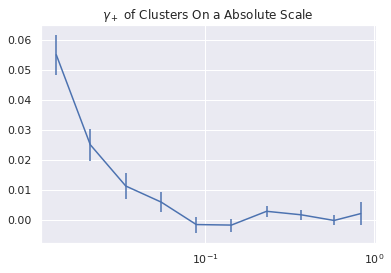

Aggregated xi:
[-17.7808 -16.0556 -11.786  -10.4142   4.4875   8.2437 -19.6411 -14.8328
   1.2861  -2.5903]
------------------------------------------------------------------------------
Aggregated meanlogr:
[-1398.4759 -2474.6798 -3524.9601 -5092.6996 -7040.968  -9337.6888
 -9980.2015 -8584.5923 -3962.7882  -222.4731]
------------------------------------------------------------------------------
Aggregated npairs:
[ 323.  640. 1042. 1757. 2908. 4807. 6820. 8639. 7297. 1228.]
------------------------------------------------------------------------------
Mean xi:
[-0.055  -0.0251 -0.0113 -0.0059  0.0015  0.0017 -0.0029 -0.0017  0.0002
 -0.0021]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3296 -3.8667 -3.3829 -2.8985 -2.4212 -1.9425 -1.4634 -0.9937 -0.5431
 -0.1812]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

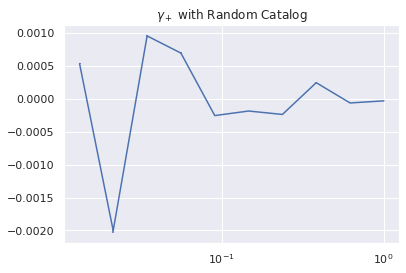

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3424e-06  3.1058e-05 -1.4862e-05 -1.0815e-05  3.9322e-06  2.8539e-06
  3.6650e-06 -3.8305e-06  9.5114e-07  4.5641e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

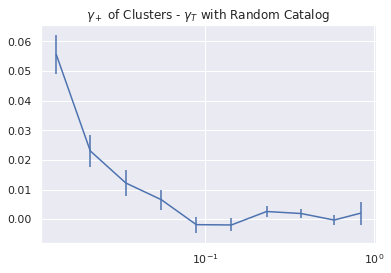

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

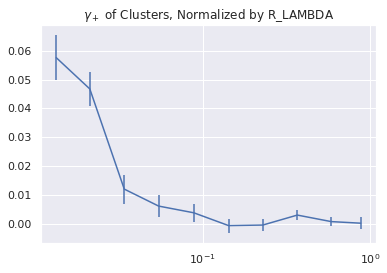

Aggregated xi:
[-10.5396 -23.0881  -9.4127  -7.9518  -8.3708   2.6414   2.9784 -23.1606
  -5.9074  -0.5261]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -789.8819 -1904.6366 -2661.9596 -3817.9641 -5446.0324 -7193.3782
 -8347.6889 -7924.221  -4749.5908  -597.0694]
------------------------------------------------------------------------------
Aggregated npairs:
[ 183.  494.  787. 1312. 2244. 3691. 5646. 7890. 8830. 4451.]
------------------------------------------------------------------------------
Mean xi:
[-0.0576 -0.0467 -0.012  -0.0061 -0.0037  0.0007  0.0005 -0.0029 -0.0007
 -0.0001]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3163 -3.8555 -3.3824 -2.91   -2.4269 -1.9489 -1.4785 -1.0043 -0.5379
 -0.1341]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)